# Neural Network

In this assignment you will build an artificial neural network _from scratch_, meaning without modern machine learning packages (e.g. scikit-learn, tensorflow, and pytorch). You should use numpy, and can use other standard python libraries if you like. 

## Part 1: Neural Network with Stochastic Gradient Descent (4 points)
Define a class NeuralNetwork that implements an artificial neural network with a single hidden layer. The hidden layer should use the Rectified Linear Unit (ReLU) non-linear activation function, and the output should have a Softmax activation function. Use the template provided. 

This first part should implement SGD with a mini-batch size of 1. This is a simplified case of Part 3, which asks you to implement mini-batch gradient descent with a mini-batch size greater than 1. You should start with Part 1 because it is simpler. However, it is fine to turn in just the solution in Part 3 because that is the more general case.

The hard part of this is the **train** method, which requires computing lots of gradients. See the [notes on neural networks](https://laulima.hawaii.edu/access/content/group/MAN.XLSIDIN35ps.202230/Notes_6__Introduction_to_Neural_Networks.pdf) on Laulima to see the equations for calculating these analytically. Translating these equations into code is non-trivial. The **backpropagation** algorithm is a dynamic programming algorithm that computes the gradients layer by layer, and can be written very elegantly in terms of matrix manipulations (a couple lines of numpy code).

_Reminder: Do NOT copy and paste code from the internet. All code should be written by you._

## Part 2: Apply Your Model to Fashion Dataset (3 points)
We will test the model on the Fashion MNIST dataset. This is a 10-class classification task designed to be similar to the MNIST digit recognition dataset. The classes are different items of clothing (shoes, shirts, handbags, etc.) instead of digits. Here is an [introduction](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) and [github page](https://github.com/zalandoresearch/fashion-mnist).

1. Demonstrate overfitting in your network by plotting the training and test set losses vs. epoch. An *epoch* is one iteration through the training set; in SGD this means one weight update for each training example. You can use a smaller dataset so that you overfit faster, but clearly state how many examples are in your train and test sets.
2. Optimize the hyperparameters of the neural network. You can try different numbers of neurons and the learning rate. Because the test dataset is fairly large (10k examples), you don't need to split off a separate validation set for this analysis. Report the best performance (validation accuracy) and the best hyperparameters. 
3. Visualize the 10 test examples with the largest loss.

## Part 3: Better and Faster: Mini-Batch SGD (3 points)
Implement mini-batch gradient descent in your NeuralNetwork train method. This is much more efficient to update the weights on *batches* of training data, e.g. 100 examples at a time, which serves two purposes: 
1. Each update is a better, less-noisy estimate of the true gradient
2. The matrix multiplications can be parallelized for an almost-linear speedup with multiple cores or a GPU. By default, numpy should automatically use multiple CPUs for matrix multiplications. This requires implementing the forward and backpropagation computations efficiently, using matrix multiplications rather than for loops. 


In [43]:
# Preliminary Stuff I did for future reference. 

# Jupyter Notebook on macOS with: [1] numpy, [2] matplotlib

In [44]:
# Part 1: Defining the neural network.

# Resources: [1] python-course.eu/
#            [2] https://het.as.utexas.edu/HET/Software/Numpy/reference/maskedarray.generic.html
#            [3] Casual Machine Learning Discord Server HW4 Chat Viewer 
#            [4] Michael Rogers ICS 435 Fall 2021 
#            [5] GeeksforGeeks 

class NeuralNetwork():
    
    def __init__(self, inputs, hidden, outputs, alpha=0.01):
        """
        Initialize a simple neural network with a single hidden layer.
        This method randomly initializes the parameters of the model,
        saving them as private variables.
        
        Each layer is parameterized by a weight matrix and a bias vector; 
        a useful trick is store the weights and biases for a layer together,
        as a single matrix.
        
        Args:
            inputs: int, input dimension
            hidden: int, number of hidden neurons
            outputs: int, number of output neurons
        Returns:
            None
        """
        
        # Initialize the weights and biases of the neural network as private variables. 
        # Store a weight matrix for each layer.
        
        self.hidden = np.random.randn(inputs + 1, hidden) * alpha
        self.output = np.random.randn(hidden + 1, outputs) * alpha
        self.softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

    def loss(self, y_true, y_pred):
        # Resource [2]: Using np.ma which is an masked array to handle incomplete data.  
        """
        Compute categorical cross-entropy loss function. 
        
        Sum loss contributions over the outputs (axis=1), but 
        average over the examples (axis=0)
        
        Args: 
            y_true: NxD numpy array with N examples, D outputs (one-hot labels).
            y_pred: NxD numpy array with N examples, D outputs (probabilities).
        Returns:
            loss: array of length N representing loss for each example.
        """
        # WRITE ME
        
        # return np.sum(y_true * np.log(y_pred), axis=1)
         
        # Clip the data 
        return np.sum(-np.ma.log(y_pred).data*y_true, axis=1) 
        
    def evaluate(self, X, y):
        """
        Make predictions and compute loss.
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
        Returns:
            loss: array of length N representing loss for each example.
        """
        # WRITE ME
        return self.loss(y, self.predict(X))
        
    def predict(self, X):
        """
        Make predictions on inputs X.
        Args:
            X: NxM numpy array where n-th row is an input.
        Returns: 
            y_pred: NxD array where n-th row is vector of probabilities.
        """
        # WRITE ME
        
        # Add bias term to inputs X and forward propagate with the ReLu activation function.
        hidden_layer = np.maximum(0, np.dot(X, self.hidden[:-1]) + self.hidden[-1])
        
        # Add bias term to hidden layer and forward propagate with the softmax activation function.
        y_pred = self.softmax(np.dot(hidden_layer, self.output[:-1]) + self.output[-1])
        
        return y_pred
    
    
    def accuracy(self, X, y):
        # Resources: [4], basically told me to have accuracy helper function outside of training function
                   # [4], helped design code logic
        """
        Check accuracy of model on inputs X with labels y.
        
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
        Returns:
            acc: Fraction of inputs in X that were correctly classified.
        """
        # Intialize Variables to hold prediction values. 
        y_pred = self.predict(X)
        y_pred_argmax = np.argmax(y_pred, axis=1)
        y_argmax = np.argmax(y, axis = 1)
        
        # Output count ratio that were correctly predicted. 
        acc = np.mean(y_pred_argmax == y_argmax)
        
        return acc
        
    def train(self, X, y, lr = 0.001, max_epochs = 5, X_val = None, y_val = None, batch_size = 100):
    # Resources Used: [1], https://python-course.eu/machine-learning/training-neural-network-with-python.php 
                    # [3], Recording of March 22 Lecture + Office Hours
                    #      https://kahawai.hawaii.edu/zoom/basic/meeting/?m=fiRtL0v9SGyW1mZMK0KiUQ%3D%3D&rs=2022-03-22+14%3A47%3A31&t=shared_screen_with_speaker_view
        """
        Train the neural network using stochastic gradient descent.
        
        Args:
            X: NxM numpy array where n-th row is an input.
            y: NxD numpy array with N examples and D outputs (one-hot labels).
            lr: scalar learning rate. Use small value for debugging.
            max_epochs: int, each epoch is one iteration through the train data.
            x_val: numpy array containing validation data inputs.
            y_val: numpy array containing validation data outputs.
        Returns:
            history: dict with the following key, value pairs:
                     'loss' -> list containing the training loss at each epoch
                     'loss_val' -> list for the validation loss at each epoch
        """
        # WRITE ME
        
        #Initialize Variables for:
        #                          softmax: probability distribution
        #                          history: dictionary output to record loss values 
        #                                N: number of rows 
        
        softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        history = {'loss': [], 'loss_val': [], 'acc': [], 'acc_val': []}
        N = X.shape[0]
        
        # Run until specified epochs is computed
        for epoch in range(max_epochs):
            
            #Default pentaly is 0 because no predictions yet
            loss = 0
            
            for batch in range(0, X.shape[0], batch_size):
                
                X_batch = X[batch:batch + batch_size]
                y_batch = y[batch:batch + batch_size]
                
                # Resources: [3], https://discord.com/channels/931331667040272444/931332838404530226/956421531523747860
                # Feed forward for next attempt 
                hidden_layer = np.maximum(0, np.dot(X_batch, self.hidden[:-1]) + self.hidden[-1])
                y_pred = softmax(np.dot(hidden_layer, self.output[:-1]) + self.output[-1])
                
                # Compute the loss from the prediction and add it to prev loss. 
                # If perfect no increase (+0), else increase (+stuff). 
                loss += np.sum(self.loss(y_batch, y_pred))
                
                # [3], March 22 Office Hours Recording 
                        # https://kahawai.hawaii.edu/zoom/basic/meeting/?m=fiRtL0v9SGyW1mZMK0KiUQ%3D%3D&rs=2022-03-22+14%3A47%3A31&t=shared_screen_with_speaker_view
                # [4], Helped with the back propagation logic
                # Back propogate to re-eval weights
                delta_output = y_pred - y_batch
                delta_hidden = np.dot(delta_output, self.output[:-1].T) * (hidden_layer > 0)
                self.output[:-1] -= lr * np.dot(hidden_layer.T, delta_output)
                self.output[-1] -= lr * np.sum(delta_output, axis=0)
                self.hidden[:-1] -= lr * np.dot(X_batch.T, delta_hidden)
                self.hidden[-1] -= lr * np.sum(delta_hidden, axis=0)
                
            # Store the loss and accuracy values into dictionary     
            history['loss'].append(loss / N)
            history['acc'].append(self.accuracy(X, y))
            
            if X_val is not None and y_val is not None:
                
                history['loss_val'].append(self.evaluate(X_val, y_val).mean())
                history['acc_val'].append(self.accuracy(X_val, y_val))
                
            print(f'Epoch: {epoch}')
            print(f'\t Training Loss: {history["loss"][-1]}, Training Accuracy: {history["acc"][-1]}')
            
            if X_val is not None and y_val is not None:
                print(f'\t Validation Loss: {history["loss_val"][-1]}, Validation Accuracy: {history["acc_val"][-1]}')
                
        return history
        

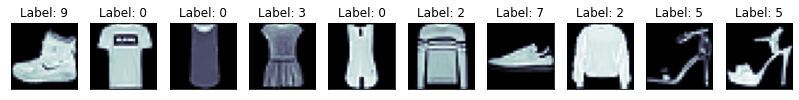

In [45]:
# From HW4 Original File
# Download Fashion MNIST Dataset

import gzip
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(435) # np.random is used so let's use a base seed if we need to check prev attempts

def fashion_mnist():
    """
    Download compressed Fashion MNIST data to local directory, and 
    unpack data into numpy arrays. 
    
    Return (train_images, train_labels, test_images, test_labels).

    Args:
        None

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values.
            Columns of labels are a onehot encoding of the correct class.
    """
    url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'
    files = ['train-images-idx3-ubyte.gz',
             'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz',
             't10k-labels-idx1-ubyte.gz']
    path = './' # Download data to current directory.
    os.makedirs(path, exist_ok=True) # Create path if it doesn't exist.

    # Download any missing files
    for file in files:
        if file not in os.listdir(path):
            urlretrieve(url + file, os.path.join(path, file))
            print("Downloaded %s to %s" % (file, path))

    def _images(path):
        """Return images loaded locally."""
        with gzip.open(path) as f:
            # First 16 bytes are magic_number, n_imgs, n_rows, n_cols
            pixels = np.frombuffer(f.read(), 'B', offset=16)
        return pixels.reshape(-1, 784).astype('float32') / 255

    def _labels(path):
        """Return labels loaded locally."""
        with gzip.open(path) as f:
            # First 8 bytes are magic_number, n_labels
            integer_labels = np.frombuffer(f.read(), 'B', offset=8)

        def _onehot(integer_labels):
            """Return matrix whose rows are onehot encodings of integers."""
            n_rows = len(integer_labels)
            n_cols = integer_labels.max() + 1
            onehot = np.zeros((n_rows, n_cols), dtype='uint8')
            onehot[np.arange(n_rows), integer_labels] = 1
            return onehot

        return _onehot(integer_labels)

    train_images = _images(os.path.join(path, files[0]))
    train_labels = _labels(os.path.join(path, files[1]))
    test_images = _images(os.path.join(path, files[2]))
    test_labels = _labels(os.path.join(path, files[3]))
    
    return train_images, train_labels, test_images, test_labels

train_images, train_labels, test_images, test_labels = fashion_mnist()

# Plot examples from dataset.
plt.figure(1, figsize=(14,6))
for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(train_images[i,:].reshape(28,28), cmap='bone')
    plt.title(f'Label: {train_labels[i].argmax()}')
    plt.xticks([])
    plt.yticks([])

In [46]:
# Initialize the neural network
model = NeuralNetwork(784, 100, 10)

# Shuffle the data
shuffle_idx = np.random.permutation(60000)
X_train = train_images[shuffle_idx]
y_train = train_labels[shuffle_idx]

# Split into train and validation sets
X_val = X_train[:5000]
y_val = y_train[:5000]
X_train = X_train[5000:]
y_train = y_train[5000:]

# Train the model
train = model.train(X = X_train, 
                    y = y_train, 
                    lr = 0.0001, 
                    max_epochs = 10,
                    X_val = X_val, 
                    y_val = y_val, 
                    batch_size = 256)

Epoch: 0
	 Training Loss: 1.88020808708456, Training Accuracy: 0.5861454545454545
	 Validation Loss: 1.2964222859212204, Validation Accuracy: 0.5722
Epoch: 1
	 Training Loss: 1.0355001789340126, Training Accuracy: 0.6776363636363636
	 Validation Loss: 0.8963402903246555, Validation Accuracy: 0.663
Epoch: 2
	 Training Loss: 0.8101018664330244, Training Accuracy: 0.7195818181818182
	 Validation Loss: 0.7762128728522528, Validation Accuracy: 0.7088
Epoch: 3
	 Training Loss: 0.7203745038889433, Training Accuracy: 0.7565636363636363
	 Validation Loss: 0.7057564130705618, Validation Accuracy: 0.75
Epoch: 4
	 Training Loss: 0.6599462525462777, Training Accuracy: 0.7799090909090909
	 Validation Loss: 0.6520440792019824, Validation Accuracy: 0.7786
Epoch: 5
	 Training Loss: 0.6142629151469143, Training Accuracy: 0.7963272727272728
	 Validation Loss: 0.6105559689996346, Validation Accuracy: 0.794
Epoch: 6
	 Training Loss: 0.5796503801742422, Training Accuracy: 0.8076181818181818
	 Validation Los

Test Loss: 0.533
Test Accuracy: 0.815


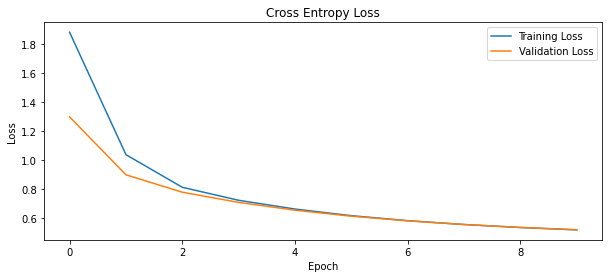

Top 10 misclassified images:


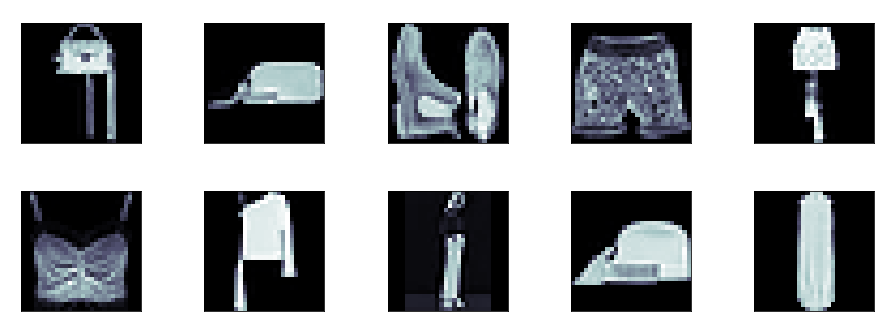

In [47]:
# Labels from provided url
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Evaluate model on test set
losses = model.evaluate(test_images, test_labels)
print(f'Test Loss: {losses.mean():.3f}')
accuracy = model.accuracy(test_images, test_labels)
print(f'Test Accuracy: {accuracy.mean():.3f}')

plt.figure(figsize=(10,4))
plt.plot(train['loss'], label = f'Training Loss')
plt.plot(train['loss_val'], label = f'Validation Loss')
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get the top 10 misclassified images

    # Reverse sort and take top 10
top_ten = losses.argsort()[::-1][:10] 

    # Check that the top loss is the max loss
assert losses[top_ten[0]] == max(losses) 

# Get the top 10 most likely classes for those images
y_pred = model.predict(test_images[top_ten])
y_pred_labels = [labels[y_pred[i].argmax()] for i in range(10)]
y_true_labels = [labels[test_labels[top_ten[i]].argmax()] for i in range(10)]

print(f'Top 10 misclassified images:')
 
# Plot the top 10 most likely classes for those images along with the true classes and the loss
fig, ax = plt.subplots(2, 5, figsize=(15,5))

# Resources: Plot based on sample code
#            [4], helped with the logic for plot cleaning. 
for i in range(5):
    ax[0,i].imshow(test_images[top_ten[i]].reshape(28,28), cmap='bone')
    ax[0,i].set_title(f'Prediction: {y_pred_labels[i]}', color='w')
    ax[0,i].set_ylabel(f'True: {y_true_labels[i]}', color='w')
    ax[0,i].set_xlabel(f'Loss: {losses[top_ten[i]]:.3f}', color='w')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
# Resources: Plot based on sample code
#            [4], helped with the logic for plot cleaning. 
for i in range(5):
    ax[1,i].imshow(test_images[top_ten[i+5]].reshape(28,28), cmap='bone')
    ax[1,i].set_title(f'Prediction: {y_pred_labels[i+5]}', color='w')
    ax[1,i].set_ylabel(f'True: {y_true_labels[i+5]}', color='w')
    ax[1,i].set_xlabel(f'Loss: {losses[top_ten[i+5]]:.3f}', color='w')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    
# Resources: [5], https://www.geeksforgeeks.org/how-to-create-subplots-in-matplotlib-with-python/
# Adjust plot for better viewing
plt.subplots_adjust(left = 0.1,
                    bottom = 0.1, 
                    right = 0.9, 
                    top = 0.9, 
                    wspace = 0.4, 
                    hspace = 0.4)
plt.show()

In [48]:
# Train the model again with more epochs to show how it overfits

# Initialize the neural network
model = NeuralNetwork(784, 400, 10)

# Shuffle the data
shuffle_idx = np.random.permutation(60000)
X_train = train_images[shuffle_idx]
y_train = train_labels[shuffle_idx]

# Split into train and validation sets
X_val = X_train[:5000]
y_val = y_train[:5000]
X_train = X_train[5000:]
y_train = y_train[5000:]

# Train the model
train = model.train(X = X_train, y = y_train, lr=0.001, max_epochs=100,
                    X_val = X_val, y_val = y_val, batch_size=256)


Epoch: 0
	 Training Loss: 0.8260118217466359, Training Accuracy: 0.8172545454545455
	 Validation Loss: 0.5293494301898093, Validation Accuracy: 0.818
Epoch: 1
	 Training Loss: 0.5103809325869495, Training Accuracy: 0.8412545454545455
	 Validation Loss: 0.45059269305385424, Validation Accuracy: 0.8398
Epoch: 2
	 Training Loss: 0.4479416227261787, Training Accuracy: 0.8541272727272727
	 Validation Loss: 0.41499324762104106, Validation Accuracy: 0.8542
Epoch: 3
	 Training Loss: 0.41382917625196625, Training Accuracy: 0.861909090909091
	 Validation Loss: 0.3936075695934339, Validation Accuracy: 0.8608
Epoch: 4
	 Training Loss: 0.3907792604006187, Training Accuracy: 0.8688727272727272
	 Validation Loss: 0.3772403913930668, Validation Accuracy: 0.8672
Epoch: 5
	 Training Loss: 0.37316907423853724, Training Accuracy: 0.8742909090909091
	 Validation Loss: 0.36502022327410516, Validation Accuracy: 0.8688
Epoch: 6
	 Training Loss: 0.35842926187019314, Training Accuracy: 0.8792909090909091
	 Vali

Epoch: 54
	 Training Loss: 0.1500963482279306, Training Accuracy: 0.9446363636363636
	 Validation Loss: 0.2895645793147359, Validation Accuracy: 0.9004
Epoch: 55
	 Training Loss: 0.14450332692585097, Training Accuracy: 0.9455818181818182
	 Validation Loss: 0.28841037966735794, Validation Accuracy: 0.9028
Epoch: 56
	 Training Loss: 0.14220816180908655, Training Accuracy: 0.9440545454545455
	 Validation Loss: 0.2964936456191417, Validation Accuracy: 0.8996
Epoch: 57
	 Training Loss: 0.13941230548101952, Training Accuracy: 0.9473272727272727
	 Validation Loss: 0.2890699774231093, Validation Accuracy: 0.903
Epoch: 58
	 Training Loss: 0.1352662714427319, Training Accuracy: 0.9461818181818182
	 Validation Loss: 0.2963221217694787, Validation Accuracy: 0.9002
Epoch: 59
	 Training Loss: 0.13657328835575874, Training Accuracy: 0.9449272727272727
	 Validation Loss: 0.3004429931184502, Validation Accuracy: 0.901
Epoch: 60
	 Training Loss: 0.13393372032546483, Training Accuracy: 0.9494363636363636

Training Loss: 0.072 (Accuracy: 0.961)
Validation Loss: 0.354 (Accuracy: 0.900)
############################################################
Printing test loss and accuracy to show that it is overfit ...
  Test Loss: 0.411
  Test Accuracy: 0.888


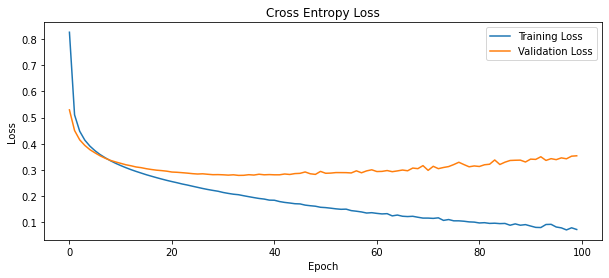

In [49]:
# Resources: [5], https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/

# Evaluate model on test set to show overfit
print(f'Training Loss: {train["loss"][-1]:.3f} (Accuracy: {train["acc"][-1]:.3f})')
print(f'Validation Loss: {train["loss_val"][-1]:.3f} (Accuracy: {train["acc_val"][-1]:.3f})')

# Print test loss and accuracy to show overfit
print('############################################################')
print("Printing test loss and accuracy to show that it is overfit ...")
losses = model.evaluate(test_images, test_labels)
print(f'  Test Loss: {losses.mean():.3f}')

accuracy = model.accuracy(test_images, test_labels)
print(f'  Test Accuracy: {accuracy.mean():.3f}')

plt.figure(figsize = (10,4))
plt.plot(train['loss'], label = f'Training Loss')
plt.plot(train['loss_val'], label = f'Validation Loss')
plt.title('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()